# Word Embeddings 

## imports

if you don't have 'bidi' or 'arabic_reshaper' you have to install them as it will help print Arabic words in matplotlib

In [ ]:
# ! pip install python-bidi

In [ ]:
# ! pip install arabic-reshaper

In [1]:
import numpy as np
from utils2 import sigmoid, get_batches, get_dict_mod, 
                    normalize_arabic, remove_diacritics, get_arabic_and_full_stop
import nltk

import re
import os

from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import arabic_reshaper

## Process text

In [5]:
%%time

data = []
root = '.\\data'
# get all files
files_paths = [ os.path.join(path, name) for path, subdirs, files in os.walk(root) for name in files]

# loop over files and process them, then append them to the data list
for file_path in files_paths:

    f = open(file_path, 'r', encoding='utf-8')

    for line in f :
        text = remove_diacritics(line)
        text = normalize_arabic(text)
        text = get_arabic_and_full_stop(text)
        data += text
    f.close()

.\data\cbow2\regular
----------------------------------------
.\data\cbow2\regular\articlesSports
----------------------------------------
.\data\cbow2\regular\cleaned
----------------------------------------
.\data\cbow2\regular\Khaleej-2004
----------------------------------------
.\data\cbow2\regular\Khaleej-2004\Economy
----------------------------------------
.\data\cbow2\regular\Khaleej-2004\International news
----------------------------------------
.\data\cbow2\regular\Khaleej-2004\Local News
----------------------------------------
.\data\cbow2\regular\Khaleej-2004\Sports
----------------------------------------
.\data\cbow2\regular\try
----------------------------------------
Wall time: 1min 18s


In [6]:
%%time
print("Number of tokens:", len(data),'\n', data[:50])               #  print data sample

Number of tokens: 45980851 
 ['اتحاد', 'الكره', 'يتلقي', 'دعوه', 'من', 'اللجنه', 'التنظيميه', 'اتحاد', 'القوي', 'يكثف', 'اتصالاته', 'لتامين', 'معسكر', 'خارجي', 'لمنتخبنا', 'للشباب', 'منتخبنا', 'الوطني', 'لرفع', 'الاثقال', 'يحقق', 'فضيه', 'وبرونزيتين', 'في', 'البطوله', 'العربيه', 'بالاردن', 'اليوم', 'مباريات', 'في', 'دوري', 'الثانيه', 'لكره', 'القدم', 'ترشح', 'خلفان', 'المنذري', 'لعضويه', 'اتحاد', 'الكره', 'الاستعدادات', 'جاريه', 'علي', 'قدم', 'وساق', 'لاحتضان', 'رالي', 'عمان', 'الدولي', 'اليوم']
Wall time: 1.99 ms


## Filter wrong words

In [7]:
%%time
data = [word for word in data if len(set(word))>=2 or word == '.']

Wall time: 1min 35s


In [8]:
len(data)

44806762

## compute frequency

In [10]:
%%time
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(data)
print("Size of vocabulary: ",len(fdist) )
print("Most frequent tokens: ",fdist.most_common(20)) # print the 20 most frequent words and their freq.

Size of vocabulary:  648548
Most frequent tokens:  [('في', 1414243), ('من', 1137348), ('.', 1126488), ('علي', 685550), ('ان', 664873), ('الي', 530909), ('التي', 392604), ('عن', 269344), ('الذي', 265533), ('ما', 187592), ('مع', 179239), ('لا', 153767), ('هذا', 150641), ('بعد', 146226), ('هذه', 139885), ('حيث', 126159), ('لم', 114602), ('او', 110935), ('كان', 106399), ('كل', 105756)]
Wall time: 50 s


## Filter rare words

In [17]:
%%time
data = [word for word in data if fdist[word] > 2]

Wall time: 29.3 s


In [18]:
len(data)

44351752

## Mapping words to indices and indices to words

In [19]:
%%time
word2Ind = get_dict_mod(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  279241
Wall time: 6.73 s


In [20]:
word2Ind['طفل']

145379

<a name='2'></a>
# 2 Training the Model

###  Initializing the model

In [22]:
def initialize_model(N,V, random_seed=1):
    
    np.random.seed(random_seed)
    
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)

    return W1, W2, b1, b2

<a name='2.1'></a>
### 2.1 Softmax
Before we can start training the model, we need to implement the softmax function as defined in equation 5:  

<br>
$$ \text{softmax}(z_i) = \frac{e^{z_i} }{\sum_{i=0}^{V-1} e^{z_i} }  \tag{5} $$

In [24]:
def softmax(z):

    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    
    return yhat

<a name='2.2'></a>
### 2.2 Forward propagation

<a name='ex-03'></a>
### Exercise 03
Implement the forward propagation $z$ according to equations (1) to (3). <br>

\begin{align}
 h &= W_1 \  X + b_1  \tag{1} \\
 a &= ReLU(h)  \tag{2} \\
 z &= W_2 \  a + b_2   \tag{3} \\
\end{align}

For that, you will use as activation the Rectified Linear Unit (ReLU) given by:

$$f(h)=\max (0,h) \tag{6}$$

In [26]:
def forward_prop(x, W1, W2, b1, b2):

    # Calculate h
    h = np.dot(W1,x)+b1
    
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    
    # Calculate z
    z = np.dot(W2,h)+b2
    
    return z, h

<a name='2.3'></a>
## 2.3 Cost function

In [28]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y) + np.multiply(np.log(1 - yhat), 1 - y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

<a name='2.4'></a>
## 2.4 Training the Model - Backpropagation

![back proba](back_porp.png)

In [30]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = np.sum((1/batch_size)*np.dot(l1,x.T),axis=1,keepdims=True)
    # Compute the gradient of b2
    grad_b2 = np.sum((1/batch_size)*np.dot(yhat-y,h.T),axis=1,keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

<a name='2.5'></a>
## Train

In [32]:
def train(data, word2Ind, N, V, num_iters, C=2, batch_size=128, alpha=0.03):

    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    iters = 0
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):

        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 2 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 -= alpha*grad_W1 
        W2 -= alpha*grad_W2
        b1 -= alpha*grad_b1
        b2 -= alpha*grad_b2
        
        ### END CODE HERE ###
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [34]:
%%time
C = 2
batch_size = 128
V = len(word2Ind)
num_iters = 20
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters, C, batch_size)

Call gradient_descent
iters: 2 cost: 14.706067
iters: 4 cost: 0.004671
iters: 6 cost: 0.004275
iters: 8 cost: 0.003942
iters: 10 cost: 0.003657
iters: 12 cost: 0.003411
iters: 14 cost: 0.003196
iters: 16 cost: 0.003007
iters: 18 cost: 0.002839
iters: 20 cost: 0.002689
Wall time: 4min 6s


<a name='3'></a>
## 3.0 Visualizing the word vectors

In [228]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['ملك', 
         'ملكه',
         'رجل',
         'امراه',
         'طفل',
         'طفله',
         'حرب',
         'سلام',
         'الارض',
         'السماء',
         'الكواكب',
         'النجوم',
         'القمر',
        ]

idx = [word2Ind[word] for word in words]

embs = (W1.T[idx, :] + W2[idx, :])/2.0
 
X = embs
print(X.shape, idx)

(13, 300) [210548, 210563, 126529, 63134, 145361, 145379, 117560, 134467, 16485, 35724, 46177, 59721, 44848]


In [229]:
words = [get_display(arabic_reshaper.reshape(word)) for word in words]

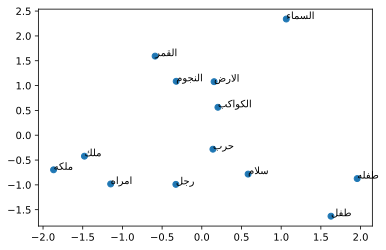

In [230]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 1], result[:, 0])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 1], result[i, 0]))
pyplot.show()